In [1]:
import sys
import os
import yaml
from azure.identity import AzureCliCredential, DefaultAzureCredential
from azure.keyvault.secrets import SecretClient
from azure.storage.blob import BlobServiceClient, BlobClient

root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_path)

In [2]:
import pandas as pd
import seaborn as sns
from utils.helpers import (read_data_from_github_zip,
                           preprocess_date_columns,
                           preprocess_time_columns,)

In [3]:
with open("../config.yml", "r") as f:
    config = yaml.safe_load(f)

ONLINE_ADDRESS = config['data']['online_address']
DATA_PATH = config['data']['current_table']
OLD_DATA_PATH = config['data']['path_old_data']
ACCOUNT_URL = config['data']['account_url']
CONTAINER_NAME = config['data']['azure_container_name']


default_credential = DefaultAzureCredential()

# Create the BlobServiceClient object
blob_service_client = BlobServiceClient(ACCOUNT_URL, credential=default_credential)
container_client = blob_service_client.get_container_client(CONTAINER_NAME)

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
url = 'https://github.com/MLOpsGDA/mlops_fire_fighter/raw/main/data/LFB_Incident.csv.zip'
df = read_data_from_github_zip(url)

In [6]:
df.head(5)

,IncidentNumber,DateOfCall,CalYear,TimeOfCall,HourOfCall,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,AddressQualifier,Postcode_full,Postcode_district,UPRN,USRN,IncGeo_BoroughCode,IncGeo_BoroughName,ProperCase,IncGeo_WardCode,IncGeo_WardName,IncGeo_WardNameNew,Easting_m,Northing_m,Easting_rounded,Northing_rounded,Latitude,Longitude,FRS,IncidentStationGround,FirstPumpArriving_AttendanceTime,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpHoursRoundUp,Notional Cost (£),NumCalls
0,051451-01052020,01 May 2020,2020,00:03:18,0,False Alarm,False alarm - Good intent,NaN,Dwelling,Self contained Sheltered Housing,Within same building,NaN,SE11,0,22500349,E09000028,SOUTHWARK,Southwark,E05011114,ST. GEORGE'S,ST. GEORGE'S,NaN,NaN,531450,178950,NaN,NaN,London,Lambeth,180.0,Lambeth,192.0,Lambeth,2.0,3.0,3.0,2.0,692.0,1.0
1,051452-01052020,01 May 2020,2020,00:03:32,0,False Alarm,False alarm - Good intent,NaN,Dwelling,House - single occupancy,Correct incident location,NaN,E7,0,22207988,E09000025,NEWHAM,Newham,E05013913,Green Street East,Green Street East,NaN,NaN,541250,184250,NaN,NaN,London,East Ham,293.0,Stratford,420.0,Leytonstone,2.0,2.0,2.0,1.0,346.0,1.0
2,051453-01052020,01 May 2020,2020,00:05:55,0,Special Service,Special Service,Effecting entry/exit,Dwelling,House - single occupancy,Correct incident location,NaN,BR1,0,20301711,E09000006,BROMLEY,Bromley,E05014004,Plaistow,Plaistow,NaN,NaN,540450,171550,NaN,NaN,London,Bromley,393.0,Bromley,NaN,NaN,1.0,1.0,1.0,1.0,346.0,2.0
3,051455-01052020,01 May 2020,2020,00:25:06,0,Special Service,Special Service,Hazardous Materials incident,Dwelling,Purpose Built Flats/Maisonettes - 10 or more s...,Within same building,NaN,E14,0,22702346,E09000030,TOWER HAMLETS,Tower Hamlets,E05009318,Blackwall & Cubitt Town,Blackwall & Cubitt Town,NaN,NaN,538750,180850,NaN,NaN,London,Poplar,338.0,Millwall,422.0,Shadwell,2.0,2.0,2.0,2.0,692.0,1.0
4,051456-01052020,01 May 2020,2020,00:28:07,0,False Alarm,AFA,NaN,Dwelling,House - single occupancy,Correct incident location,NaN,W5,0,20600595,E09000009,EALING,Ealing,E05013520,Ealing Broadway,Ealing Broadway,NaN,NaN,517550,181150,NaN,NaN,London,Ealing,233.0,Ealing,364.0,Acton,2.0,2.0,2.0,2.0,692.0,1.0


In [7]:
container_client.upload_blob(DATA_PATH,
                             df.to_parquet(),
                             overwrite=True)

### DateOfCall
This feature will be used to extract the month of the call as a new feature, and then the this feature will be dropped.

In [8]:
df['DateOfCall'].unique()

array(['01 May 2020', '02 May 2020', '03 May 2020', ..., '28 Apr 2023',
       '29 Apr 2023', '30 Apr 2023'], dtype=object)

In [9]:
df = preprocess_date_columns(df, 'DateOfCall')

In [10]:
df['DateOfCall_Month']

0         5
1         5
2         5
3         5
4         5
         ..
340169    4
340170    4
340171    4
340172    4
340173    4
Name: DateOfCall_Month, Length: 340174, dtype: int64

### CalYear

The years 2020, 2021, and 2022 will be used for training. Year 2023 will serve as test data. This feature will be dropped.

In [11]:
df['CalYear'].value_counts()

2022    125390
2021    109577
2020     67519
2023     37688
Name: CalYear, dtype: int64

### TimeOfCall
This feature will be used to extract part of the days information as a new feature, and then this feature will be dropped.

In [12]:
df['TimeOfCall'].unique()

array(['00:03:18', '00:03:32', '00:05:55', ..., '19:10:50', '20:00:01',
       '23:52:17'], dtype=object)

In [13]:
df = preprocess_time_columns(df, 'TimeOfCall')

In [14]:
df['PartOfDay'].value_counts(dropna=False)

Evening      125622
Afternoon     92405
Morning       80424
Night         41723
Name: PartOfDay, dtype: int64

### HourOfCall

<Axes: >

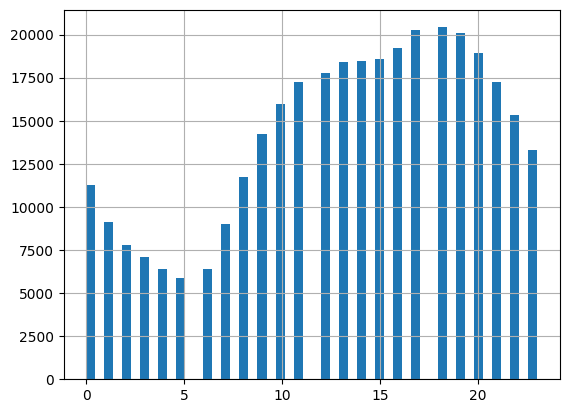

In [15]:
df['HourOfCall'].hist(bins=50)

### IncidentGroup

In [16]:
df['IncidentGroup'].unique()

array(['False Alarm', 'Special Service', 'Fire'], dtype=object)

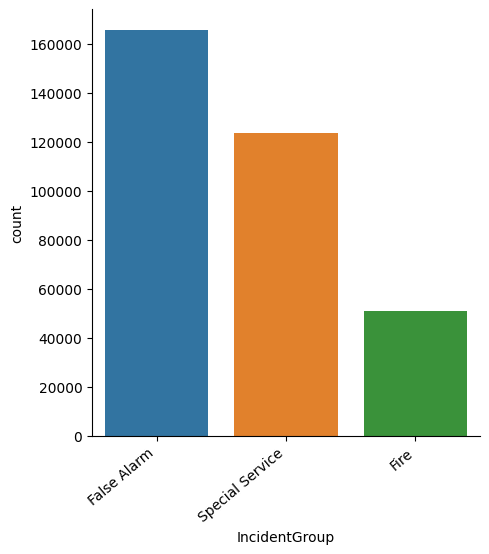

In [17]:
sns.catplot(x='IncidentGroup', kind='count', data=df).set_xticklabels(rotation=40, ha='right')

### StopCodeDescription
Consider groupping the rare levels.

In [18]:
df['StopCodeDescription'].unique()

array(['False alarm - Good intent', 'Special Service', 'AFA',
       'Primary Fire', 'Secondary Fire', 'False alarm - Malicious',
       'Flood call attended - Batch mobilised',
       'Use of Special Operations Room', 'Chimney Fire', 'Late Call'],
      dtype=object)

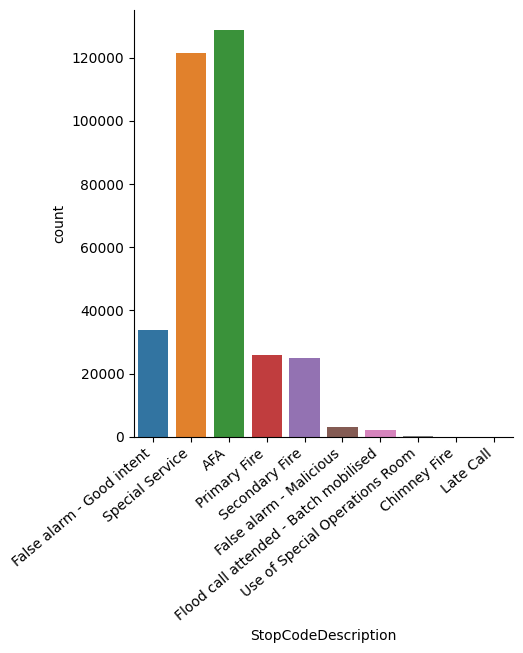

In [19]:
sns.catplot(x='StopCodeDescription', kind='count', data=df).set_xticklabels(rotation=40, ha='right')

In [20]:
df['StopCodeDescription'].value_counts()/df.shape[0]

AFA                                      0.378377
Special Service                          0.357238
False alarm - Good intent                0.099728
Primary Fire                             0.076249
Secondary Fire                           0.073257
False alarm - Malicious                  0.008931
Flood call attended - Batch mobilised    0.005785
Use of Special Operations Room           0.000244
Chimney Fire                             0.000135
Late Call                                0.000056
Name: StopCodeDescription, dtype: float64

### SpecialServiceType
This feature will be dropped since NaN values make up to 64% of the cases.

In [21]:
df['SpecialServiceType'].unique()

array([nan, 'Effecting entry/exit', 'Hazardous Materials incident',
       'Flooding', 'Animal assistance incidents', 'RTC',
       'No action (not false alarm)', 'Other rescue/release of persons',
       'Removal of objects from people', 'Lift Release',
       'Spills and Leaks (not RTC)', 'Making Safe (not RTC)',
       'Suicide/attempts', 'Medical Incident', 'Assist other agencies',
       'Advice Only', 'Other Transport incident', 'Stand By',
       'Evacuation (no fire)', 'Rescue or evacuation from water',
       'Water provision'], dtype=object)

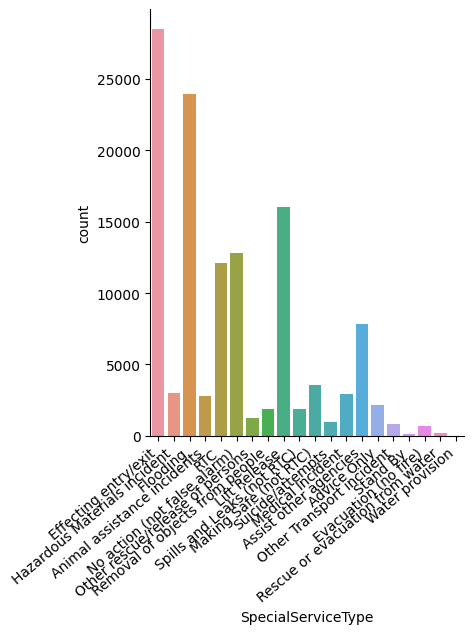

In [22]:
sns.catplot(x='SpecialServiceType', kind='count', data=df).set_xticklabels(rotation=40, ha='right')

In [23]:
df['SpecialServiceType'].value_counts(dropna=False)/df.shape[0]

NaN                                0.636977
Effecting entry/exit               0.083722
Flooding                           0.070402
Lift Release                       0.047049
No action (not false alarm)        0.037707
RTC                                0.035676
Assist other agencies              0.023041
Making Safe (not RTC)              0.010518
Hazardous Materials incident       0.008772
Medical Incident                   0.008660
Animal assistance incidents        0.008231
Advice Only                        0.006411
Spills and Leaks (not RTC)         0.005444
Removal of objects from people     0.005441
Other rescue/release of persons    0.003675
Suicide/attempts                   0.002754
Other Transport incident           0.002369
Evacuation (no fire)               0.002037
Rescue or evacuation from water    0.000650
Stand By                           0.000456
Water provision                    0.000006
Name: SpecialServiceType, dtype: float64

### PropertyCategory
Consider groupping the rare levels.

In [24]:
df['PropertyCategory'].unique()

array(['Dwelling', 'Non Residential', 'Road Vehicle', 'Other Residential',
       'Outdoor', 'Outdoor Structure', 'Rail Vehicle', 'Boat', 'Aircraft'],
      dtype=object)

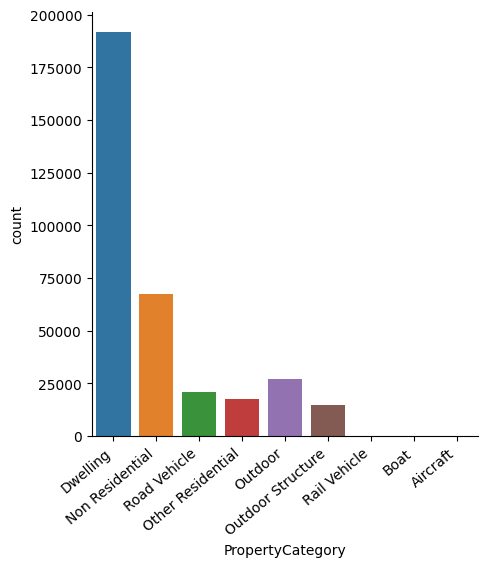

In [25]:
sns.catplot(x='PropertyCategory', kind='count', data=df).set_xticklabels(rotation=40, ha='right')

In [26]:
df['PropertyCategory'].value_counts(dropna=False)/df.shape[0]

Dwelling             0.564011
Non Residential      0.198925
Outdoor              0.079871
Road Vehicle         0.061245
Other Residential    0.051291
Outdoor Structure    0.042878
Rail Vehicle         0.000814
Boat                 0.000547
Aircraft             0.000417
Name: PropertyCategory, dtype: float64

### PropertyType
Consider groupping the rare levels.

In [27]:
df['PropertyType'].unique()

array(['Self contained Sheltered Housing ', 'House - single occupancy ',
       'Purpose Built Flats/Maisonettes - 10 or more storeys ',
       'Warehouse ', 'Purpose Built Flats/Maisonettes - Up to 3 storeys ',
       'Converted Flat/Maisonette - Up to 2 storeys ',
       'Purpose built office ',
       'Purpose Built Flats/Maisonettes - 4 to 9 storeys ',
       'College/University ', 'Shopping Centre ', 'Car ', 'Van ',
       'Leisure Centre ', 'Doctors surgery',
       'Hostel (e.g. for homeless people) ',
       'Bungalow - single occupancy ',
       'Domestic garden (vegetation not equipment) ', 'Restaurant/cafe',
       'Other Residential Home ', 'Library ', 'Pub/wine bar/bar ',
       'Single shop ', 'Lorry/HGV ', 'Converted office ',
       'Licensed House in Multiple Occupation - 3 or more storeys ',
       'Converted Flat/Maisonettes - 3 or more storeys',
       'Nursing/Care Home/Hospice', 'Motorcycle ',
       'Retirement/Old Persons Home', 'Infant/Primary school',
       '

In [28]:
df['PropertyType'].value_counts(dropna=False)/df.shape[0]

Purpose Built Flats/Maisonettes - 4 to 9 storeys      0.152055
House - single occupancy                              0.121573
Purpose Built Flats/Maisonettes - Up to 3 storeys     0.113189
Self contained Sheltered Housing                      0.047549
Converted Flat/Maisonettes - 3 or more storeys        0.041311
                                                        ...   
Greenhouse (commercial) glass                         0.000003
Boat - Tanker                                         0.000003
Mine or quarry (not above ground building)            0.000003
Military plane                                        0.000003
Greenhouse (commercial) polytunnel                    0.000003
Name: PropertyType, Length: 285, dtype: float64

### AddressQualifier
Consider grouping the rare levels.

In [29]:
df['AddressQualifier'].unique()

array(['Within same building', 'Correct incident location',
       'In street outside gazetteer location',
       'On motorway / elevated road', 'On land associated with building',
       'Nearby address - no building in street',
       'In street close to gazetteer location',
       'Open land/water - nearest gazetteer location',
       'Nearby address - street not listed in gazetteer',
       'In street remote from gazetteer location',
       'Railway land or rolling stock'], dtype=object)

In [30]:
df['AddressQualifier'].value_counts(dropna=False)/df.shape[0]

Correct incident location                          0.586294
Within same building                               0.227795
On land associated with building                   0.061469
In street outside gazetteer location               0.060607
In street close to gazetteer location              0.026266
Open land/water - nearest gazetteer location       0.024091
Nearby address - street not listed in gazetteer    0.003581
Nearby address - no building in street             0.003163
On motorway / elevated road                        0.002996
In street remote from gazetteer location           0.002208
Railway land or rolling stock                      0.001532
Name: AddressQualifier, dtype: float64

### Postcode_full
This feature will be dropped.

In [31]:
df['Postcode_full'].unique()

array([nan, 'CR0 4RR', 'DA15 7DG', ..., 'W3 7JE', 'DA5 3BE', 'NW3 2HX'],
      dtype=object)

### Postcode_district
This feature will be dropped.

In [32]:
df['Postcode_district'].unique()

array(['SE11', 'E7', 'BR1', 'E14', 'W5', 'CR0', 'N16', 'BR2', 'N18', 'N4',
       'DA15', 'NW1', 'DA18', 'SW15', 'E9', 'IG11', 'BR6', 'W12', 'E13',
       'TW9', 'N1', 'E6', 'EN2', 'W11', 'IG4', 'TW5', 'W9', 'SE8', 'E5',
       'NW3', 'SW16', 'SE10', 'W14', 'SW19', 'HA9', 'SW18', 'N14', 'SM1',
       'SW1W', 'SE12', 'NW10', 'SE1', 'WC1B', 'SE27', 'TW8', 'NW7',
       'EC1M', 'E16', 'RM13', 'SW2', 'NW9', 'W13', 'DA1', 'E15', 'EC3V',
       'RM11', 'EN1', 'W1S', 'UB6', 'DA7', 'CR7', 'CR5', 'TW14', 'N22',
       'RM3', 'W10', 'SW4', 'SE15', 'N20', 'NW6', 'SW7', 'W3', 'KT2',
       'EC2Y', 'EC2A', 'DA16', 'NW2', 'SW1X', 'SE5', 'EN5', 'HA5', 'EC1V',
       'E4', 'HA0', 'IG8', 'SW1Y', 'WC1E', 'SE17', 'E1', 'E12', 'EC1N',
       'UB3', 'HA4', 'UB8', 'N2', 'N19', 'KT3', 'E2', 'N13', 'NW4', 'TW2',
       'TW13', 'W2', 'E8', 'TW1', 'SE18', 'SE2', 'SW9', 'SW17', 'E3',
       'NW8', 'SW3', 'TW6', 'N12', 'SE26', 'W8', 'UB4', 'E11', 'TW10',
       'UB10', 'E18', 'RM6', 'SE25', 'W4', 'DA14', 'UB2', '

### UPRN
This feature will be dropped.

In [33]:
df['UPRN'].unique()

array([           0, 100022905329, 100022919470, ..., 100022730133,
            5030035,  10094942504], dtype=int64)

### USRN
This feature will be dropped

In [34]:
df['USRN'].unique()

array([22500349, 22207988, 20301711, ..., 22605958, 20301000, 20600081],
      dtype=int64)

### IncGeo_BoroughName
This feature will be dropped (same as ProperCase).

In [35]:
df['IncGeo_BoroughName'].unique()

array(['SOUTHWARK', 'NEWHAM', 'BROMLEY', 'TOWER HAMLETS', 'EALING',
       'CROYDON', 'HACKNEY', 'ENFIELD', 'HARINGEY', 'BEXLEY', 'CAMDEN',
       'WANDSWORTH', 'BARKING AND DAGENHAM', 'HAMMERSMITH AND FULHAM',
       'RICHMOND UPON THAMES', 'ISLINGTON', 'KENSINGTON AND CHELSEA',
       'REDBRIDGE', 'HOUNSLOW', 'WESTMINSTER', 'LEWISHAM', 'LAMBETH',
       'GREENWICH', 'MERTON', 'BRENT', 'SUTTON', 'BARNET', 'HAVERING',
       'CITY OF LONDON', 'KINGSTON UPON THAMES', 'HARROW',
       'WALTHAM FOREST', 'HILLINGDON'], dtype=object)

### ProperCase

In [36]:
df['ProperCase'].unique()

array(['Southwark', 'Newham', 'Bromley', 'Tower Hamlets', 'Ealing',
       'Croydon', 'Hackney', 'Enfield', 'Haringey', 'Bexley', 'Camden',
       'Wandsworth', 'Barking And dagenham', 'Hammersmith And fulham',
       'Richmond Upon thames', 'Islington', 'Kensington And chelsea',
       'Redbridge', 'Hounslow', 'Westminster', 'Lewisham', 'Lambeth',
       'Greenwich', 'Merton', 'Brent', 'Sutton', 'Barnet', 'Havering',
       'City Of london', 'Kingston Upon thames', 'Harrow',
       'Waltham Forest', 'Hillingdon'], dtype=object)

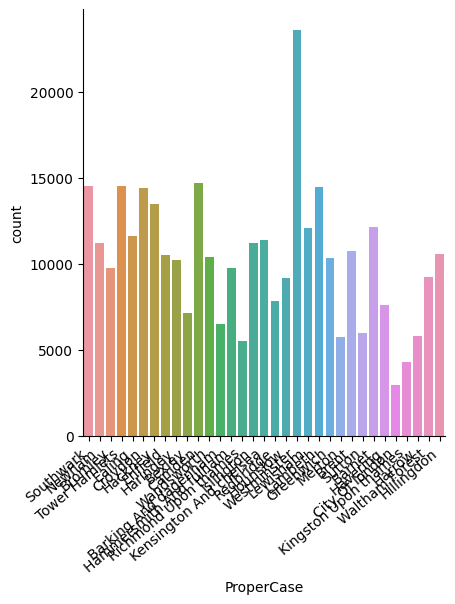

In [37]:
sns.catplot(x='ProperCase', kind='count', data=df).set_xticklabels(rotation=40, ha='right')

In [38]:
df['ProperCase'].value_counts(dropna=False)/df.shape[0]

Westminster               0.069491
Camden                    0.043281
Tower Hamlets             0.042799
Southwark                 0.042781
Lambeth                   0.042602
Croydon                   0.042502
Hackney                   0.039721
Barnet                    0.035693
Lewisham                  0.035535
Ealing                    0.034291
Kensington And chelsea    0.033600
Newham                    0.033021
Islington                 0.032992
Brent                     0.031663
Hillingdon                0.031125
Enfield                   0.030972
Wandsworth                0.030696
Greenwich                 0.030411
Haringey                  0.030114
Bromley                   0.028732
Hammersmith And fulham    0.028691
Waltham Forest            0.027215
Hounslow                  0.027098
Redbridge                 0.023068
Havering                  0.022427
Bexley                    0.020998
Barking And dagenham      0.019140
Sutton                    0.017609
Harrow              

### IncGeo_WardCode
This feature will be dropped.

In [39]:
df['IncGeo_WardCode'].unique()

array(['E05011114', 'E05013913', 'E05014004', 'E05009318', 'E05013520',
       'E05011487', 'E05009373', 'E05013991', 'E05013679', 'E05013600',
       'E05011230', 'E05013668', 'E05011232', 'E05014017', 'E05009374',
       'E05014061', 'E05013997', 'E05013737', 'E05013905', 'E05013786',
       'E05013709', 'E05013693', 'E05009392', 'E05011255', 'E05013617',
       'E05013800', 'E05013719', 'E05009383', 'E05013652', 'E05014112',
       'E05014076', 'E05013734', 'E05013820', 'E05013497', 'E05014026',
       'E05013692', 'E05013765', 'E05013797', 'E05014084', 'E05013509',
       'E05011095', 'E05013653', 'E05014106', 'E05013608', 'E05013630',
       'E05013662', 'E05013907', 'E05013979', 'E05013919', 'E05014113',
       'E05013649', 'E05013541', 'E05011222', 'E05013917', 'E05009301',
       'E05013982', 'E05013677', 'E05013808', 'E05014066', 'E05013534',
       'E05013753', 'E05011217', 'E05011486', 'E05013720', 'E05011474',
       'E05013613', 'E05009399', 'E05013603', 'E05013971', 'E050

### IncGeo_WardName
Consider grouping the rare levels.

In [40]:
df['IncGeo_WardName'].unique()

array(["ST. GEORGE'S", 'Green Street East', 'Plaistow', ...,
       'WORCESTER PARK SOUTH', 'COOMBE VALE', 'HOUNSLOW SOUTH'],
      dtype=object)

In [41]:
df['IncGeo_WardName'].value_counts(dropna=False)/df.shape[0]

West End                0.009713
St. James's             0.007361
WEST END                0.005671
FAIRFIELD               0.004686
ST. JAMES'S             0.004636
                          ...   
Chelsea Riverside       0.000003
Brompton & Hans Town    0.000003
Queen's Gate            0.000003
St. Giles               0.000003
De Beauvoir             0.000003
Name: IncGeo_WardName, Length: 1294, dtype: float64

### IncGeo_WardNameNew
This feature will be dropped since same as IncGeo_WardName.

In [42]:
df['IncGeo_WardNameNew'].unique()

array(["ST. GEORGE'S", 'Green Street East', 'Plaistow', ...,
       'WORCESTER PARK SOUTH', 'COOMBE VALE', 'HOUNSLOW SOUTH'],
      dtype=object)

In [43]:
df['IncGeo_WardNameNew'].value_counts(dropna=False)/df.shape[0]

West End                0.009713
St. James's             0.007361
WEST END                0.005671
FAIRFIELD               0.004686
ST. JAMES'S             0.004636
                          ...   
Chelsea Riverside       0.000003
Brompton & Hans Town    0.000003
Queen's Gate            0.000003
St. Giles               0.000003
De Beauvoir             0.000003
Name: IncGeo_WardNameNew, Length: 1294, dtype: float64

### Easting_m
This feature will be dropped.

In [44]:
df['Easting_m'].unique()

array([    nan, 531044., 546298., ..., 540196., 519597., 519443.])

### Northing_m
This feature will be dropped.

In [45]:
df['Northing_m'].unique()

array([    nan, 163681., 172407., ..., 196057., 166602., 172833.])

### Easting_rounded
This feature will be dropped.

In [46]:
df['Easting_rounded'].unique()

array([531450, 541250, 540450, 538750, 517550, 531050, 533950, 540750,
       534950, 546250, 529150, 548050, 521650, 536150, 544150, 545050,
       522150, 541550, 517950, 533250, 532750, 524450, 541650, 512850,
       525550, 536750, 534850, 526350, 530250, 539250, 524050, 524950,
       520150, 526550, 528950, 525450, 528450, 540350, 521550, 531850,
       534150, 529950, 531750, 517050, 521450, 531550, 521150, 539850,
       554750, 540650, 530550, 521750, 516250, 552650, 539550, 532950,
       553950, 534350, 528850, 543750, 516650, 522250, 549950, 532150,
       539650, 530650, 510250, 524150, 531950, 553750, 522750, 524250,
       529050, 535250, 526850, 525350, 521850, 524550, 520450, 519850,
       532250, 533650, 533350, 525850, 522850, 527950, 532550, 537250,
       524650, 527050, 525650, 512250, 532450, 537850, 516850, 535150,
       529650, 529350, 532850, 532050, 543250, 545250, 531350, 509450,
       510850, 507850, 523950, 526950, 530050, 529750, 527250, 521350,
      

### Northing_rounded
This feature will be dropped.

In [47]:
df['Northing_rounded'].unique()

array([178950, 184250, 171550, 180850, 181150, 163650, 186250, 168350,
       192750, 187450, 172450, 183350, 179250, 175250, 185050, 183450,
       166250, 179650, 196550, 181050, 188350, 177650, 182550, 177750,
       187050, 184750, 170250, 178150, 178450, 169750, 186650, 174250,
       194750, 164750, 174850, 179950, 192550, 181950, 171350, 178250,
       191750, 181850, 174350, 181450, 184050, 182050, 173150, 188450,
       180250, 175550, 187550, 197450, 184550, 183950, 180550, 176150,
       169050, 158850, 174950, 189950, 192250, 182850, 182450, 175850,
       193850, 182750, 178550, 170150, 181650, 195350, 172550, 171050,
       178850, 186850, 179550, 177250, 165050, 168050, 192450, 179150,
       170750, 196450, 188950, 186350, 191650, 166450, 186950, 192050,
       182250, 178650, 167750, 181350, 186050, 178750, 181550, 182150,
       189650, 185350, 168150, 165850, 189150, 181250, 173350, 190650,
       171250, 174050, 166750, 178050, 193450, 173250, 182950, 168850,
      

### Latitude
This feature will be dropped.

In [48]:
df['Latitude'].unique()

array([        nan, 51.357095  , 51.43178562, ..., 51.46139646,
       51.47809972, 51.46521844])

### Longitude
This feature will be dropped.

In [49]:
df['Longitude'].unique()

array([        nan, -0.119327  ,  0.10320611, ..., -0.11443344,
       -0.34084683, -0.30087744])

### FRS
This feature will be dropped since it has one value.

In [50]:
df['FRS'].unique()

array(['London'], dtype=object)

### IncidentStationGround
This feature will be dropped since too many values are availabe with small frequencies.

In [51]:
df['IncidentStationGround'].unique()

array(['Lambeth', 'East Ham', 'Bromley', 'Poplar', 'Ealing', 'Croydon',
       'Stoke Newington', 'Edmonton', 'Holloway', 'Sidcup', 'Euston',
       'Erith', 'Richmond', 'Homerton', 'Barking', 'Orpington',
       'Hammersmith', 'Plaistow', 'Islington', 'Enfield',
       'North Kensington', 'Ilford', 'Heston', 'Paddington', 'Deptford',
       'West Hampstead', 'Norbury', 'East Greenwich', 'Wimbledon',
       'Wembley', 'Wandsworth', 'Southgate', 'Sutton', 'Chelsea',
       'Lee Green', 'Willesden', 'Dowgate', 'West Norwood', 'Mill Hill',
       'Shoreditch', 'Wennington', 'Hendon', 'Bexley', 'Stratford',
       'Hornchurch', 'Soho', 'Purley', 'Feltham', 'Tottenham',
       'Harold Hill', 'Clapham', 'New Cross', 'Barnet', 'Acton',
       'New Malden', 'Plumstead', 'Kensington', 'Peckham', 'Addington',
       'Dockhead', 'Harrow', 'Chingford', 'Woodford', 'Old Kent Road',
       'Shadwell', 'Hayes', 'Ruislip', 'Hillingdon', 'Finchley',
       'Kentish Town', 'Woodside', 'Bethnal Green', '

In [52]:
df['IncidentStationGround'].value_counts(dropna=False)/df.shape[0]

Soho                    0.030176
Paddington              0.024946
Lambeth                 0.019622
Euston                  0.019131
Shoreditch              0.018067
                          ...   
Wennington              0.004074
Hainault                0.004042
Biggin Hill             0.001476
Beyond Home Counties    0.000003
NaN                     0.000003
Name: IncidentStationGround, Length: 104, dtype: float64

### FirstPumpArriving_AttendanceTime
This is the target feature in seconds. The target feature's values will be converted to minutes so the range is not to big, and the incidents having na values will be dropped.

In [53]:
df['FirstPumpArriving_AttendanceTime'].describe()

count    320032.000000
mean        311.279094
std         131.924699
min           1.000000
25%         228.000000
50%         293.000000
75%         371.000000
max        1200.000000
Name: FirstPumpArriving_AttendanceTime, dtype: float64

<Axes: >

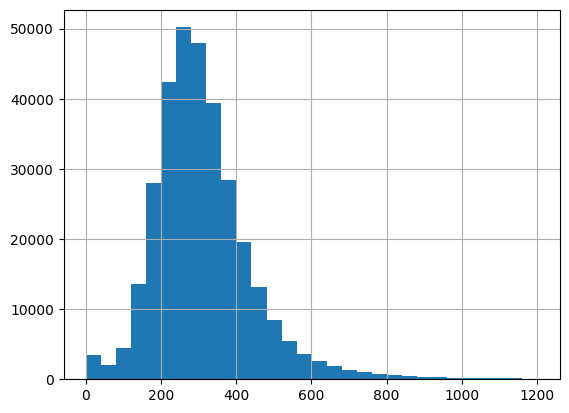

In [54]:
df['FirstPumpArriving_AttendanceTime'].hist(bins=30)

In [55]:
df['FirstPumpArriving_AttendanceTime_min'] = df['FirstPumpArriving_AttendanceTime']/60
df['FirstPumpArriving_AttendanceTime_min'].describe()

count    320032.000000
mean          5.187985
std           2.198745
min           0.016667
25%           3.800000
50%           4.883333
75%           6.183333
max          20.000000
Name: FirstPumpArriving_AttendanceTime_min, dtype: float64

<Axes: >

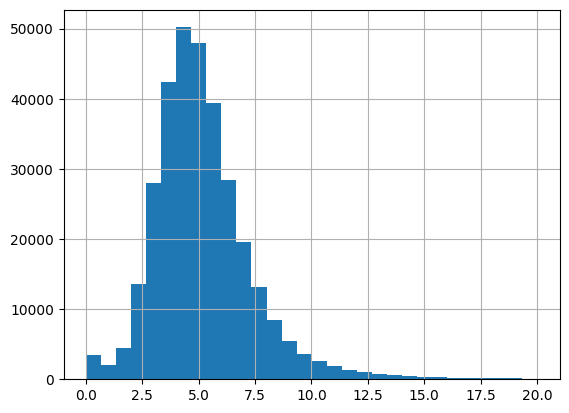

In [56]:
df['FirstPumpArriving_AttendanceTime_min'].hist(bins=30)

### FirstPumpArriving_DeployedFromStation
This feature will be dropped since too many values and very low frequencies.

In [57]:
df['FirstPumpArriving_DeployedFromStation'].unique()

array(['Lambeth', 'Stratford', 'Bromley', 'Millwall', 'Ealing', 'Croydon',
       'Stoke Newington', 'Edmonton', 'Holloway', 'Sidcup', 'Euston',
       'Erith', 'Wandsworth', 'Homerton', 'Barking', 'Richmond',
       'Orpington', 'Hammersmith', 'Plaistow', 'Islington', 'East Ham',
       'Enfield', 'North Kensington', 'Ilford', 'Heston', 'Paddington',
       'Greenwich', nan, 'West Hampstead', 'Norbury', 'Wimbledon',
       'Wembley', 'Southgate', 'Sutton', 'Chelsea', 'Lee Green',
       'Willesden', 'Dowgate', 'West Norwood', 'Mill Hill', 'Shoreditch',
       'Wennington', 'Brixton', 'Hendon', 'Bexley', 'Hornchurch', 'Soho',
       'Purley', 'Feltham', 'Hornsey', 'Harold Hill', 'Clapham',
       'Peckham', 'Barnet', 'Acton', 'Kingston', 'Plumstead',
       'Kensington', 'Addington', 'Tottenham', 'Northolt', 'Woodford',
       'Old Kent Road', 'Shadwell', 'Heathrow', 'Ruislip', 'Hillingdon',
       'Finchley', 'New Malden', 'Woodside', 'Bethnal Green',
       'Whitechapel', 'Twickenham

In [58]:
df['FirstPumpArriving_DeployedFromStation'].value_counts(dropna=False)/df.shape[0]

NaN              0.059226
Soho             0.028797
Paddington       0.021248
Lambeth          0.017900
Euston           0.017315
                   ...   
Purley           0.004354
Hainault         0.003284
Wennington       0.002584
Biggin Hill      0.001243
Hertfordshire    0.000003
Name: FirstPumpArriving_DeployedFromStation, Length: 104, dtype: float64

### SecondPumpArriving_AttendanceTime
This feature will be dropped since too many nas, and no need of further investigation.

In [59]:
df['SecondPumpArriving_AttendanceTime'].describe()

count    122989.000000
mean        391.471164
std         144.898956
min           1.000000
25%         298.000000
50%         369.000000
75%         458.000000
max        1200.000000
Name: SecondPumpArriving_AttendanceTime, dtype: float64

### SecondPumpArriving_DeployedFromStation
This feature will be dropped.

In [60]:
df['SecondPumpArriving_DeployedFromStation'].unique()

array(['Lambeth', 'Leytonstone', nan, 'Shadwell', 'Acton', 'Beckenham',
       'Edmonton', 'Soho', 'Richmond', 'Stoke Newington', 'Barking',
       'Wandsworth', 'Hammersmith', 'East Ham', 'Plaistow', 'Ilford',
       'Old Kent Road', 'Battersea', 'Southgate', 'Sutton',
       'West Norwood', 'Ealing', 'Enfield', 'Euston', 'Northolt', 'Erith',
       'Romford', 'Paddington', 'Peckham', 'Kensington', 'Dowgate',
       'Brixton', 'Kingston', 'Chelsea', 'Norbury', 'Tooting',
       'Whitechapel', 'Woodford', 'Woodside', 'Wembley', 'Chingford',
       'Homerton', 'Hayes', 'Finchley', 'West Hampstead', 'Croydon',
       'Hornsey', 'Wallington', 'Twickenham', 'Tottenham', 'Feltham',
       'Plumstead', 'Fulham', 'Islington', 'Southall', 'Bromley',
       'Hillingdon', 'Sidcup', 'Kentish Town', 'Shoreditch', 'Greenwich',
       'Lee Green', 'Deptford', 'Clapham', 'Hendon', 'Lewisham',
       'Orpington', 'Leyton', 'New Cross', 'Willesden', 'Heathrow',
       'Heston', 'North Kensington', 'Chi

### NumStationsWithPumpsAttending

In [61]:
df['NumStationsWithPumpsAttending'].describe()

count    334943.000000
mean          1.406093
std           0.791723
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          14.000000
Name: NumStationsWithPumpsAttending, dtype: float64

<Axes: >

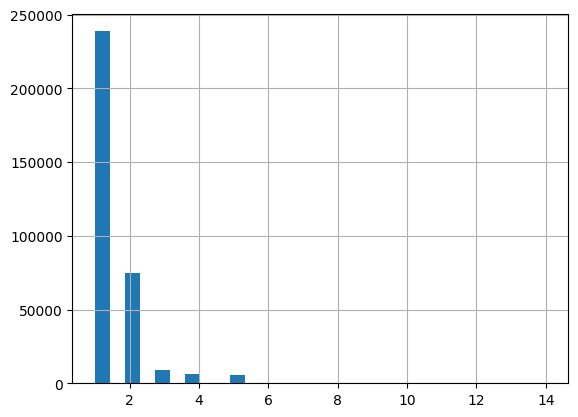

In [62]:
df['NumStationsWithPumpsAttending'].hist(bins=30)

### NumPumpsAttending

In [63]:
df['NumPumpsAttending'].describe()

count    334943.000000
mean          1.545424
std           0.915680
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          14.000000
Name: NumPumpsAttending, dtype: float64

<Axes: >

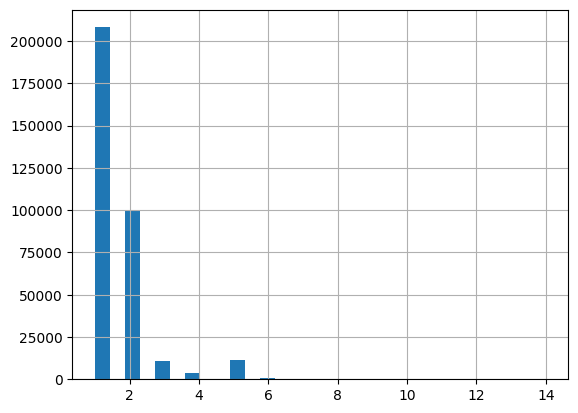

In [64]:
df['NumPumpsAttending'].hist(bins=30)

### PumpCount
This feature will be dropped since highly correlated with NumPumpsAttending.

In [65]:
df['PumpCount'].describe()

count    337214.000000
mean          1.595242
std           1.369999
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         156.000000
Name: PumpCount, dtype: float64

<Axes: >

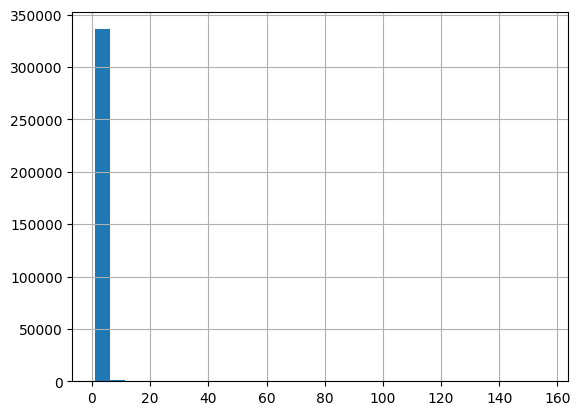

In [66]:
df['PumpCount'].hist(bins=30)

In [67]:
df[['PumpCount', 'NumPumpsAttending']].corr()

,PumpCount,NumPumpsAttending
PumpCount,1.000000,0.711609
NumPumpsAttending,0.711609,1.000000


### PumpHoursRoundUp
This feature will be dropped since no information from the modeling perspective.

In [68]:
df['PumpHoursRoundUp'].describe()

count    337120.000000
mean          1.364419
std           4.299975
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         680.000000
Name: PumpHoursRoundUp, dtype: float64

<Axes: >

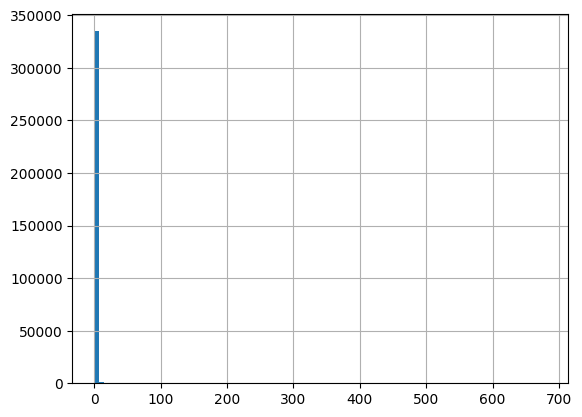

In [69]:
df['PumpHoursRoundUp'].hist(bins=100)

### Notional Cost (£)
The value of this feature will be capped to 400 since the std is to big.

In [70]:
df['Notional Cost (£)'].describe()

count    327967.000000
mean        485.104678
std        1546.549090
min         346.000000
25%         352.000000
50%         352.000000
75%         364.000000
max      247520.000000
Name: Notional Cost (£), dtype: float64

<Axes: >

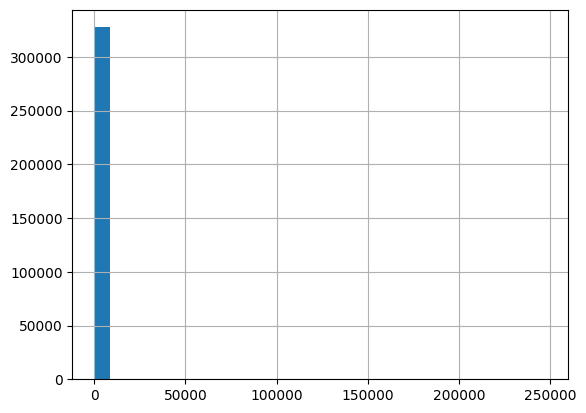

In [71]:
df['Notional Cost (£)'].hist(bins=30)

### NumCalls

In [72]:
df['NumCalls'].describe()

count    340172.000000
mean          1.310899
std           1.475325
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         111.000000
Name: NumCalls, dtype: float64

## Feature sets

The lists below contain the features available in the data.

- target_feature: the target feature
- drop_features: features that will be dropped and are not considered
- cat_features: the categorical features
- num_features: the numerical features 
- id_feature: the id feature

In [73]:
target = 'FirstPumpArriving_AttendanceTime_min'

drop_features = ['DateOfCall', 'CalYear', 'TimeOfCall', 'SpecialServiceType', 'Postcode_full',
                 'Postcode_district', 'UPRN', 'USRN', 'IncGeo_BoroughName', 'IncGeo_WardCode',
                 'IncGeo_WardNameNew', 'Easting_m', 'Northing_m', 'Easting_rounded', 'Northing_rounded',
                 'Latitude', 'Longitude', 'FRS', 'IncidentStationGround', 'FirstPumpArriving_AttendanceTime',
                 'SecondPumpArriving_AttendanceTime', 'SecondPumpArriving_DeployedFromStation',
                 'PumpCount', 'PumpHoursRoundUp']

cat_features = ['IncidentGroup', 'StopCodeDescription', 'PropertyCategory', 'PropertyType',
                'AddressQualifier', 'ProperCase', 'IncGeo_WardName', 'PartOfDay']

num_features = ['HourOfCall', 'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'Notional Cost (£)',
                'NumCalls', 'DateOfCall_Month']

id_feature = 'IncidentNumber'

## DATA INGESTION & TRACKING

In [74]:
mobilisation = pd.read_excel("https://data.london.gov.uk/download/london-fire-brigade-mobilisation-records/3ff29fb5-3935-41b2-89f1-38571059237e/LFB%20Mobilisation%20data%20Last%203%20years.xlsx")
incidents = pd.read_csv("https://data.london.gov.uk/download/london-fire-brigade-incident-records/f5066d66-c7a3-415f-9629-026fbda61822/LFB%20Incident%20data%20Last%203%20years.csv")

In [75]:
mobilisation.head()

,IncidentNumber,CalYear,HourOfCall,ResourceMobilisationId,Resource_Code,PerformanceReporting,DateAndTimeMobilised,DateAndTimeMobile,DateAndTimeArrived,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,DateAndTimeLeft,DateAndTimeReturned,DeployedFromStation_Code,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,PlusCode_Code,PlusCode_Description,DelayCodeId,DelayCode_Description
0,000003-01012020,2020,0,5547476,G232,1,01/01/2020 00:06:30,01/01/2020 00:07:48,01/01/2020 00:11:54,78.0,246.0,324,01/01/2020 00:33:14,NaN,G23,Hillingdon,Home Station,1,Initial,Initial Mobilisation,NaN,NaN
1,000008-01012020,2020,0,5547478,H421,1,01/01/2020 00:11:05,01/01/2020 00:12:05,01/01/2020 00:14:20,60.0,135.0,195,01/01/2020 01:00:07,NaN,H42,Richmond,Home Station,1,Initial,Initial Mobilisation,NaN,NaN
2,000009-01012020,2020,0,5547479,A341,1,01/01/2020 00:11:16,01/01/2020 00:13:04,01/01/2020 00:18:22,108.0,318.0,426,01/01/2020 00:52:05,NaN,A34,Edmonton,Home Station,1,Initial,Initial Mobilisation,9.0,"Traffic, roadworks, etc"
3,000003-01012020,2020,0,5547480,G231,2,01/01/2020 00:11:33,01/01/2020 00:12:36,01/01/2020 00:16:25,63.0,229.0,292,01/01/2020 00:21:29,NaN,G23,Hillingdon,Home Station,2,Initial,Initial Mobilisation,NaN,NaN
4,000011-01012020,2020,0,5547482,H351,1,01/01/2020 00:12:02,01/01/2020 00:13:08,01/01/2020 00:16:11,66.0,183.0,249,01/01/2020 00:44:39,NaN,H35,Tooting,Home Station,1,Initial,Initial Mobilisation,NaN,NaN


In [76]:
incidents.head()

,IncidentNumber,DateOfCall,CalYear,TimeOfCall,HourOfCall,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,AddressQualifier,Postcode_full,Postcode_district,UPRN,USRN,IncGeo_BoroughCode,IncGeo_BoroughName,ProperCase,IncGeo_WardCode,IncGeo_WardName,IncGeo_WardNameNew,Easting_m,Northing_m,Easting_rounded,Northing_rounded,Latitude,Longitude,FRS,IncidentStationGround,FirstPumpArriving_AttendanceTime,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpHoursRoundUp,Notional Cost (£),NumCalls
0,000001-01012020,01 Jan 2020,2020,00:02:11,0,Special Service,Special Service,Lift Release,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,Within same building,NaN,SE1,0,21901000,E09000022,LAMBETH,Lambeth,E05014118,Waterloo & South Bank,Waterloo & South Bank,NaN,NaN,531050,179550,NaN,NaN,London,Lambeth,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,339.0,3.0
1,000003-01012020,01 Jan 2020,2020,00:06:30,0,Fire,Primary Fire,NaN,Non Residential,Private Garden Shed,On land associated with building,NaN,UB8,0,21402055,E09000017,HILLINGDON,Hillingdon,E05013566,Colham & Cowley,Colham & Cowley,NaN,NaN,506750,181550,NaN,NaN,London,Hillingdon,324.0,Hillingdon,292.0,Hillingdon,1.0,2.0,2.0,1.0,339.0,3.0
2,000004-01012020,01 Jan 2020,2020,00:07:07,0,Special Service,Special Service,Lift Release,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,Within same building,NaN,N6,0,21106425,E09000014,HARINGEY,Haringey,E05013592,Highgate,Highgate,NaN,NaN,528250,187850,NaN,NaN,London,Hornsey,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,339.0,1.0
3,000008-01012020,01 Jan 2020,2020,00:11:05,0,False Alarm,AFA,NaN,Non Residential,Telephone exchange,Correct incident location,TW9 1LW,TW9,10002252088,22403714,E09000027,RICHMOND UPON THAMES,Richmond Upon thames,E05013786,South Richmond,South Richmond,518296.0,174887.0,518250,174850,51.460614,-0.298579,London,Richmond,195.0,Richmond,NaN,NaN,1.0,1.0,1.0,1.0,339.0,1.0
4,000009-01012020,01 Jan 2020,2020,00:11:16,0,Fire,Secondary Fire,NaN,Outdoor Structure,Small refuse/rubbish container,On land associated with building,N9 8NB,N9,207090844,20703225,E09000010,ENFIELD,Enfield,E05013685,Lower Edmonton,Lower Edmonton,535304.0,194202.0,535350,194250,51.630370,-0.046492,London,Edmonton,426.0,Edmonton,NaN,NaN,1.0,1.0,1.0,1.0,339.0,1.0


In [77]:
len(df.columns)

42

In [78]:
len(mobilisation.columns)

22

In [79]:
len(incidents.columns)

39